# Porto Seguro's Safe Driver Prediction

This notebook was written using guidance from a really great tutorial by Kaggle user Anisotropic:
### [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial)



The aim of this notebook is to explore the interactive data visualization tools offered by plot.ly, and build a random forest model to make predictions using any insights I can gain from the data.

In this project, Porto Seguro has provided driver characteristic data related to car insurance claims. The objective is as follows:

## Problem Description
Predict the probability that a driver will file a claim in the next year and use those probabilities for rankings of drivers most likely to file a claim.

### Data Exploration

We first begin by loading in the necessary packages for the data analysis

In [40]:
# for general handling and manipulation of table data
import pandas as pd
import numpy as np

# for visualization of missing data entries
import missingno as msno

# for generation of interactive data visualization
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# for decision tree and random forest model predictions/result analysis
from sklearn.ensemble import RandomForestClassifier

# start a random seed for reproducibility of results
np.random.seed(1)

Next we will load the data and get a sense of the general structure of information available

In [6]:
train_data = pd.read_csv('train.csv')

In [3]:
print('train_data({0[0]},{0[1]})'.format(train_data.shape))

print('Number of training examples: {0}'.format(train_data.shape[0]))
print('Number of features for each example: {0}'.format(train_data.shape[1]))

train_data(595212,59)
Number of training examples: 595212
Number of features for each example: 59


Below is a list of the labels for each of the 59 data features

In [4]:
pd.DataFrame(data = {'Feature Label': train_data.columns})

,Feature Label
0,id
1,target
2,ps_ind_01
3,ps_ind_02_cat
4,ps_ind_03
5,ps_ind_04_cat
6,ps_ind_05_cat
7,ps_ind_06_bin
8,ps_ind_07_bin
9,ps_ind_08_bin


The data has the following feature structure within its 59 features:

ID - identifier of the driver 

target - indicates whether or not a claim was filed for that driver

For the rest of the feature labels:
1. The "ps" prefix occurs before all features (presumably for "Porto Seguro")

2. Features are then grouped into the following categories

    a. 'ind' - contains 18 features (these features are relating to **ind**ividual)

    b. 'reg' - contains 3 features (these features are relating to **reg**ion)

    c. 'car' - contains 15 features (these features are relating to  **car**)

    d. 'calc' - contains 20 features (these are **calc**ulated features)

3. In addition, some features have post have the following suffixes:
    a. 'cat' - used to denote that the feature is categorical
    b. 'bin' - used to denote that the feature is binary
    
In order to keep things a little neater, we will drop the "ps" prefix from the feature labels.

In [7]:
no_ps = [train_data.columns[x][3:] for x in range(2, len(train_data.columns))]
train_data.columns = train_data.columns[:2].tolist() + no_ps

We are also given the information from Porto Seguro that missing data in this dataset is marked by a '-1' value. Any columns with a '-1' value present are listed below along with the number of missing entries for each of these columns.

In [6]:
NA_columns = train_data.columns[train_data.isin(['-1']).any()]
NA_data_counts = train_data.isin(['-1']).sum()[train_data.isin(['-1']).any()]
pd.DataFrame(data = NA_data_counts, columns = ['# of missing entries'])

,# of missing entries
ind_02_cat,216
ind_04_cat,83
ind_05_cat,5809
reg_03,107772
car_01_cat,107
car_02_cat,5
car_03_cat,411231
car_05_cat,266551
car_07_cat,11489
car_09_cat,569


We can see that a few columns such as 'reg_03', 'car_03_cat' and 'car_05_cat', among others, have a significant amount of missing data entries.  This is something that we will explore later on, but for now we will ignore the missing values and work with the original training data set provided.

We can also visualize the missing data in these columns by using the missingno package.

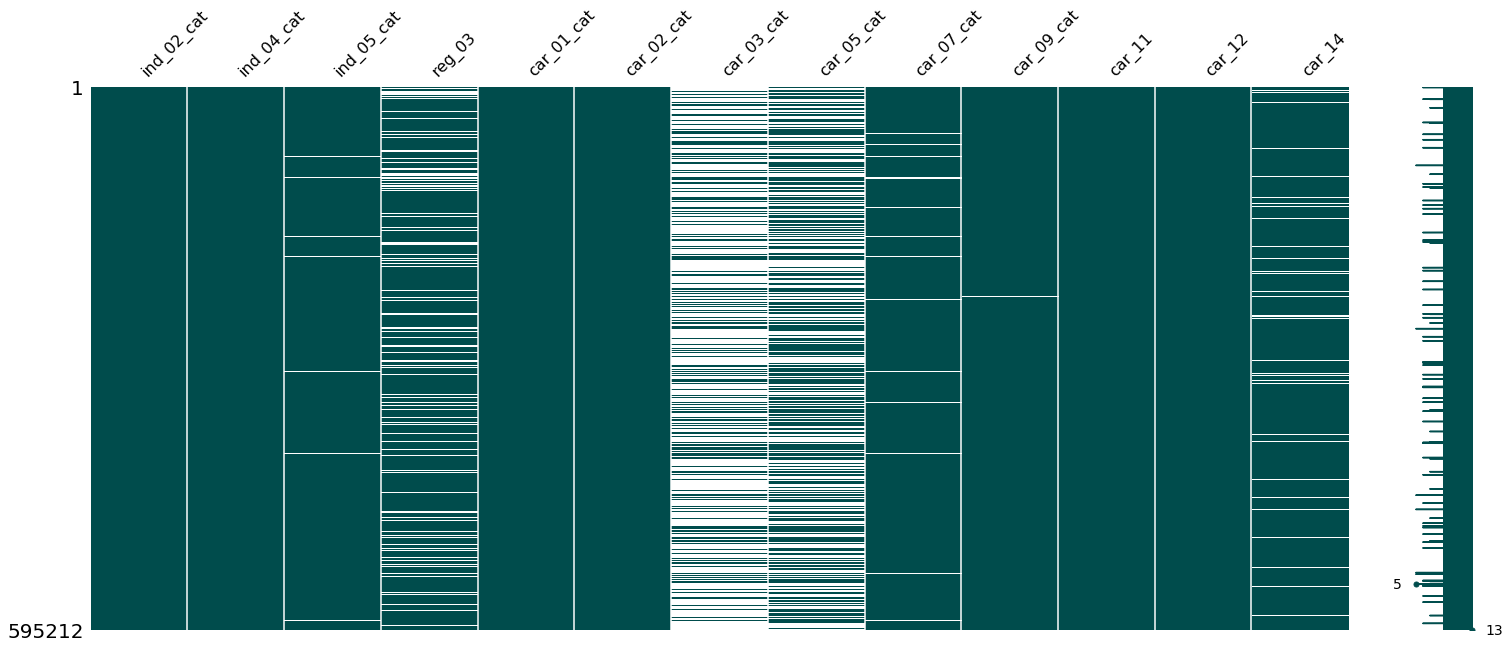

In [7]:
NA_data = train_data[NA_columns].replace(-1, np.NaN)
msno.matrix(df=NA_data, color = (0, 0.3, 0.3))

### Visualization

Let's now begin to visualize different aspects of the data to see what we can learn about the information contained in the features we've been given.

Starting off we will look at the target variable, which is the main feature of interest we are asked to predict. The pie graph below shows the relative distribution of the target variable.

In [39]:
labels = ["Target = 0", "Target = 1"]
values = train_data["target"].value_counts().values

trace = go.Pie(labels = labels, values = values)
layout = go.Layout(title = 'Distribution of Target Variable')

fig = go.Figure(data = [trace], layout = layout)
iplot(fig, filename = 'TargetDist')

<img src= "ps_images/target_dist.png">

As we can see, the target variable is highly skewed, with only 3.64% of drivers in the training data filing a claim. This is something that we will have to keep in mind when evaluating the results of our predictions later on.

Next we will take a look at the binary variables within the dataset

In [26]:
bin_columns = train_data.columns[train_data.columns.str.contains('_bin')]

print("# of binary features: {0}".format(len(bin_columns)))

# of binary features: 17


We can use a stacked bar graph to effectively get a sense of the distribution of values within the binary features, shown below:

In [38]:
bin_counts = train_data[bin_columns].apply(pd.value_counts)

trace = []
for i in range(bin_counts.shape[0]):
    trace_temp = go.Bar(
        x= np.asarray(bin_columns),
        y= bin_counts.values[i],
        name = bin_counts.index[i]
    )
    trace.append(trace_temp)

layout = go.Layout(
    barmode = 'stack',
    title = 'Distribution of Binary Features'
)

fig = go.Figure(data = trace, layout = layout)
iplot(fig, filename = 'bin_features')

<img src= "ps_images/bin_features.png">

We should also get some information on the categorical variables in this dataset. We can do this by subsetting the categorical feature columns.

In [30]:
cat_columns = train_data.columns[train_data.columns.str.contains('_cat')]
cat_data = pd.DataFrame(data = {'# of levels': train_data[cat_columns].max()})

cat_data

,# of levels
ind_02_cat,4
ind_04_cat,1
ind_05_cat,6
car_01_cat,11
car_02_cat,1
car_03_cat,1
car_04_cat,9
car_05_cat,1
car_06_cat,17
car_07_cat,1


Similar to our binary distribution, below is a visualization of the distribution within each categorical feature. The legend on the right shows the labels provided each category. Keep in mind that '-1' denotes missing data.

In [31]:
cat_counts = train_data[cat_columns].apply(pd.value_counts)

trace = []
for i in range(cat_counts.shape[0]):
    trace_temp = go.Bar(
        x= np.asarray(cat_columns),
        y= cat_counts.values[i],
        name = cat_counts.index[i]
    )
    trace.append(trace_temp)

layout = go.Layout(
    barmode = 'stack',
    title = 'Distribution of Categorical Features'
)

fig = go.Figure(data = trace, layout = layout)
iplot(fig, filename = 'cat_features')

<img src= "ps_images/cat_features.png">

Finally, we will take a look at the remaining features

In [32]:
misc_columns = train_data.columns.drop(cat_columns).drop(bin_columns).drop(["id", "target"])

ind_columns = misc_columns[misc_columns.str.contains('ind')]
reg_columns = misc_columns[misc_columns.str.contains('reg')]
car_columns = misc_columns[misc_columns.str.contains('car')]
calc_columns = misc_columns[misc_columns.str.contains('calc')]

np.random.seed(0)

#create boxplots for 'ind' columns
trace1 = []
for i in range(len(ind_columns)):
    trace_temp = go.Box(
        y= np.random.choice(train_data[ind_columns[i]], 2000, replace=False),
        name = ind_columns[i]
    )

    trace1.append(trace_temp)

layout1 = go.Layout(
    title = 'Distribution of "ind" Features'
)

# create boxplots for 'reg' columns
trace2 = []
for i in range(len(reg_columns)):
    trace_temp = go.Box(
        y= np.random.choice(train_data[reg_columns[i]], 2000, replace=False),
        name = reg_columns[i],
        boxpoints = 'suspectedoutliers'
    )

    trace2.append(trace_temp)

layout2 = go.Layout(
    title = 'Distribution of "reg" Features'
)

# create boxplots for 'car' columns
trace3 = []
for i in range(len(car_columns)):
    trace_temp = go.Box(
        y= np.random.choice(train_data[car_columns[i]], 2000, replace=False),
        name = car_columns[i],
        boxpoints = 'suspectedoutliers',
    )

    trace3.append(trace_temp)

layout3 = go.Layout(
    title = 'Distribution of "car" Features'
)

# create boxplots for 'calc' columns
trace4 = []
for i in range(len(calc_columns)):
    trace_temp = go.Box(
        y= np.random.choice(train_data[calc_columns[i]], 2000, replace=False),
        name = calc_columns[i],
        boxpoints = 'suspectectedoutliers'
    )

    trace4.append(trace_temp)

layout4 = go.Layout(
    title = 'Distribution of "calc" Features'
)

fig1 = go.Figure(data = trace1, layout = layout1)
fig2 = go.Figure(data = trace2, layout = layout2)
fig3 = go.Figure(data = trace3, layout = layout3)
fig4 = go.Figure(data = trace4, layout = layout4)


iplot(fig1, filename = 'ind_features')
iplot(fig2, filename = 'reg_features')
iplot(fig3, filename = 'car_features')
iplot(fig4, filename = 'calc_features')

<img src= "ps_images/ind_features.png">
<img src= "ps_images/reg_features.png">
<img src= "ps_images/car_features.png">
<img src= "ps_images/calc_features.png">

We can see from the distributions above that while some features have relatively small ranges (e.g. between 0 and 1) while others have relatively larger ranges, such as ps_calc_10 and ps_ind_15, it may be useful to consider normalization in order to improve the performance of our chosen model when it comes time to optimize our predictions.

Note that a random sample of 2000 drivers was selected for the box plots, since the load is pretty heavy on my machine, but it can be adapted for a larger subset.

For now, we will work with the data as-is and begin fitting the data to Decision Tree and Random Forest (RF) models in order to get a baseline performance that we can later optimize.

In [33]:
# Separate rows where target is 0 or 1
target_data = [train_data["target"] == 0, train_data["target"] == 1]


trace = []
trace_temp = go.Box(
    y= np.random.choice(train_data['car_13'][target_data[0]],
                        2000,
                        replace=False
                       ),
    name = 'Target = 0',
    boxpoints = 'all',
    boxmean = 'sd'
)

trace.append(trace_temp)

trace_temp = go.Box(
    y= np.random.choice(train_data['car_13'][target_data[1]],
                        2000,
                        replace=False
                       ),
    name = 'Target = 1',
    boxpoints = 'all',
    boxmean = 'sd'
)

trace.append(trace_temp)

layout = go.Layout(
    title = 'car_13 Feature Distribution',
    width = 900,
    height = 1000,
)

fig = go.Figure(data = trace, layout = layout)
iplot(fig, filename = 'car_13_dist')

<img src= "ps_images/car_13_dist.png">

## Data Pre-processing

Let's begin preparing our data to build our predictive models. To start, we will split the training data into training ("train") and cross-validation ("CV") sets. The data will be split with the following distribution:

    90% train
    10% CV

In [8]:
np.random.seed(0)
CV_index = np.random.choice(train_data.shape[0], int(train_data.shape[0]*.1), replace = False)
CV = train_data.iloc[CV_index, :]
train = train_data.drop(CV_index, axis = 0)

assert(train_data.shape[0] == train.shape[0]+CV.shape[0])

print('Number of training examples: {0}'.format(train.shape[0]))
print('Number of cross-validation examples: {0}'.format(CV.shape[0]))

Number of training examples: 535691
Number of cross-validation examples: 59521


Before we get started, we want to make sure that both our training and cross-validation sets contain a distribution of 0's and 1's for the target data

In [34]:
labels = ["Target = 0", "Target = 1"]
train_values = train["target"].value_counts().values
CV_values = CV["target"].value_counts().values

trace1 = go.Pie(labels =  labels,
                values = train_values,
                domain= {"x": [0, 0.45]},
                hole = 0.3
               )

trace2 = go.Pie(labels = labels,
                values = CV_values,
                domain= {"x": [0.55, 1]},
                hole = 0.3
               )

layout = go.Layout(title = 'Distribution of Target Variable',
                    annotations = [{"text": "Train",
                                    "font": {"size": 20},
                                    "showarrow": False,
                                    "x": 0.19,
                                    "y": 0.5
                                   },
                                   {"text": "CV",
                                    "font": {"size": 20},
                                    "showarrow": False,
                                    "x": 0.8,
                                    "y": 0.5
                                   },
                                  ]
                   )

fig = go.Figure(data = [trace1, trace2], layout = layout)

iplot(fig, filename = 'train_CV_dist')

<img src= "ps_images/train_CV_dist.png">

### Random Forest Model

In [43]:
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(["id", "target"], axis=1), train.target)
features = train.drop(["id", "target"],axis=1).columns.values
print('------training done-------')

------training done-------


In [44]:
importance_df = pd.DataFrame(
    data = {'features': features,
            'Importance': rf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=True)

trace = go.Bar(
    x=importance_df.iloc[:, 0],
    y=importance_df.iloc[:, 1],
    marker=dict(color = importance_df.iloc[:, 0],
                colorscale = 'Viridis',
                reversescale = True
               ),
    name = 'Random Forest Feature Importance',
    orientation = 'h'
)

layout = go.Layout(title='Barplot of Feature Importances',
                   width = 900,
                   height = 2000,
                  )
fig = go.Figure(data=[trace], layout = layout)
iplot(fig, filename = 'feature_importance_barplot')

<img src= "ps_images/feature_importance_barplot.png">

In [106]:
#Predict probability of filing a claim (Target = 0 or 1)
rf_proba = rf.predict_proba(CV.drop(["id", "target"], axis=1))

#Isolate column of predicted probabilities that Target = 1
rf_proba_0 = rf_proba[:, 1].reshape(rf_proba.shape[0],1)

For this project the metric we will use to evaluate the performance of our model is based on the gini coefficient. This coefficient will rank the drivers in order from most to least likely to file a claim, and will compare the ranking between our predictions and the actual sorting according to our CV data.

Calculation of gini coefficient. Adapted from code submitted on 
Allstate Claim Prediction Challenge discussion boards
[here](https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703)

In [107]:
# calculate gini score for predicted probabilities
def gini(a, p):
    data = np.asarray(np.c_[a, p, np.arange(len(a))],
                      dtype=np.float
                     )
    data = data[
        np.lexsort((data[:,2], -1*data[:,1]))
    ]
    TotalLosses = data[:,0].sum()
    giniSum = data[:,0].cumsum().sum() / TotalLosses

    giniSum -= (len(a) + 1) / 2.
    return giniSum / len(a)

def gini_norm(a, p):
    return gini(a, p) / gini(a, a)

gini_coef = gini_norm(CV['target'], rf_proba_0)

print('Normalized Gini Coefficient: {0:0.3f}'.format(gini_coef))

Normalized Gini Coefficient: 0.256
